In [85]:
import nbimporter

from FunctionApprox_checkpoint import *
from Non_linear_kalman_filter import *

## Initialization

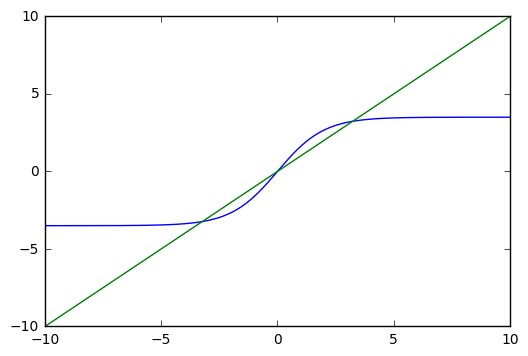

In [101]:
#Create the model

T = 1000
np.random.seed(2)


# function 1 : Gabor filter
Q = np.identity(1) * 0.2
R = np.identity(1) * 0.2
f = lambda k,x_k: 0.01*x_k+20*np.sin(x_k)*np.exp(-x_k**2/2)

# function 2 : Well
Q = np.identity(1) * 1
R = np.identity(1) * 1
f = lambda k,x_k: 0.9*x_k-50*np.exp(-x_k**2/2)+1

# # function 3 : Sigmoid
Q = np.identity(1) * 1
R = np.identity(1) * 1
f = lambda k,x_k:7*(1/(1+np.exp(-x_k))-0.5)

absc = np.linspace(-10,10,1000)
ordo = f(1,absc)

plt.figure()
plt.plot(absc,ordo)
plt.plot(absc,absc)
plt.show()


h = lambda k,x_k: (1 + 1/(k+1))*x_k

B = np.zeros([1,1])
D = np.zeros([1,1])

mean = np.zeros([1,1])

x = np.zeros((T,1))
y = np.zeros((T,1))
u = np.zeros((T,1))

#Propagation
x[0] = normal(0,10) 
for k in range(T-1):
    x[k+1] = f(k,x[k]) + np.dot(B,u[k]) + normal(mean,Q)
for k in range(T):
    y[k] = h(k,x[k])  + np.dot(D,u[k]) + normal(mean,R)

In [102]:
#trainrbf gives the values of the weights W and the covariance matrix Q
def trainrbf(X, Y, beta, numNeurons,verbose=0):
    
    #Dimensions
    #X: n x Inputdimension
    #y: n x 1
    
    #Centers are the neurons in our RBF network
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    
    if verbose:
        print("centers", centers)
    
    # calculate activations of RBFs
    Phi = activation(X, beta, numNeurons, centers)    
    Phi = np.append(Phi, X, axis =1)    
    Phi = np.append(Phi, np.ones(X.shape, "float"), axis = 1)
    
    
    
    # calculate output weights (pseudoinverse)
    W = dot(pinv(Phi), Y)
    
    #Calculate the covariance matrix Q with formula (6.18) 
    Q = (dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(Phi), Y)))
    
    L = [W, Q, centers]
    
    if verbose:
        print(W)
        print(Q)
    
    return L

def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    Phi = activation(X, beta, numNeurons, centers)    
    Phi = np.append(Phi, X, axis=1)
    Phi = np.append(Phi, np.ones((X.shape), "float"), axis=1)
    Y = dot(Phi, W) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    return Y

## EM algorithm

In [110]:
iterations = 1      # Maximum iterations of EM algorithm
numNeurons = 25       # Number of Gaussian centers(Neurons)
beta = 1              # Define the size of the kernels 

f_est = f
h_est = h
R_est = R
Q_est = Q


for it in range(iterations):    

    # E-step : EKF         
    x_f,x_b = extended_KF(x[0],y,T,f_est,h_est,R_est,Q_est)
    
    # M-step : Gaussian RBF kernels
    w,Q_est,centers_x = trainrbf(x_b[:-1], x_b[1:] , beta, numNeurons)
    v,R_est,centers_y = trainrbf(x_b, y , beta, numNeurons)
    
    f_est = lambda k,x_k: w[-2]*x_k+w[-1]
    h_est = lambda k,x_k: v[-2]*x_k+v[-1]
    
    print(it)
    

0


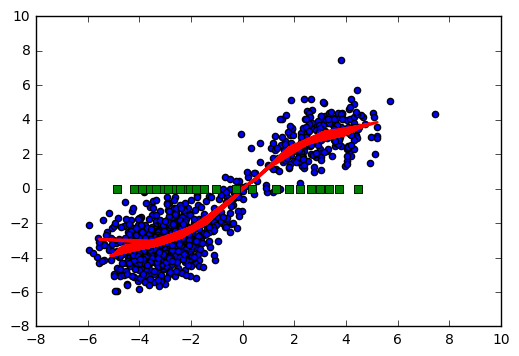

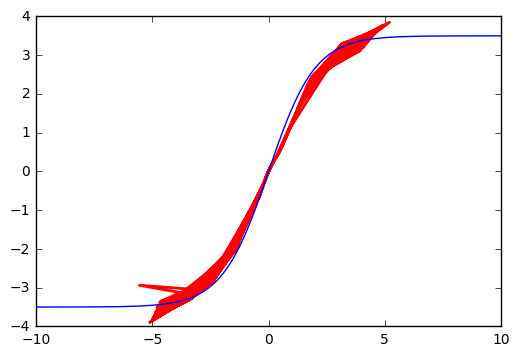

In [111]:
# TEST

z = testrbf(x_b[:-1], w,Q, beta, numNeurons, centers_x)


plt.figure()
# plot original data
plt.scatter(x[:-1], x[1:])    
# plot learned model
plt.plot(x_b[:-1], np.mean(z,1) , 'r-', linewidth=2)     
# plot rbfs
plt.plot(centers_x, zeros(numNeurons), 'gs')


plt.figure()
plt.plot(x_b[:-1], np.mean(z,1) , 'r-', linewidth=2)
absc = np.linspace(-10,10,1000)
ordo = f(1,absc)
plt.plot(absc,ordo)
plt.figure
plt.show()